# Reinforcement learning project

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np

from Chess_env import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from degree_freedom_queen import *
from generate_game import *
from neural_network import *
from utils import *

### Set Seed

In [2]:
np.random.seed(42)

### Set Hyperparameters

In [3]:
N_episodes = 100000   # number of episodes
epsilon_0 = 0.20      # starting value for epsilon greedy
beta = 0.00005        # epsilon decay rate
gamma = 0.85          # discount factor
eta = 0.0001          # learning rate for neural netowork
n_target_updates = 10 # freuqency of update for target network

# N_episodes = 100000   # number of episodes
# epsilon_0 = 0.20      # starting value for epsilon greedy
# beta = 0.0001         # epsilon decay rate
# gamma = 0.50          # discount factor
# eta = 0.0001          # learning rate for neural netowork
# n_target_updates = 10 # freuqency of update for target network


### Define environment

In [4]:
size_board = 4

env = Chess_Env(size_board)
S, X, allowed_a = env.Initialise_game()

### Define neural network

In [5]:
N_a = np.shape(allowed_a)[0]   # total number of possible actions
N_in = np.shape(X)[0]          # input size to network
N_h = 256                      # number of hidden neurons

model_nn = NeuralNetwork(input_size=N_in, output_size=N_a, hidden_size=N_h ,learning_rate = eta)  # main network
target_nn = copy.deepcopy(model_nn)                                                               # target network

### Saving variables

In [6]:
# SAVING VARIABLES
r_save = []       # save total rewards per episode
n_moves_save = [] # save number of moves per episode
win_draw = []     # save whether agent won or draw

# SARSA

In [7]:
for n in range(N_episodes):
  epsilon_f = epsilon_0 / (1 + beta * n)   # decay epsilon
  done = 0                                 # not done
  i = 1                                    # number of moves
  
  S, X, allowed_a = env.Initialise_game()      # reset environment

  X = np.concatenate([np.array(X), np.array([1])]).reshape(-1,1) # pad with one for bias

  tot_r = 0


  while done == 0:                           # start episode
    q_vals, h = model_nn.forward(X)          # get q values from network and preactivations

    action = choose_action(q_vals, allowed_a, epsilon_f) # choose action using epsilon greedy

    S_next, X_next, allowed_a_next, R, done = env.OneStep(action)  # take step
    X_next = np.concatenate([np.array(X_next), np.array([1])]).reshape(-1,1) 

    
    if done==1:  # episode is done
      target = R  # target reward
      if(R==10): # if won
        win_draw.append(1)
      else:      # if draw
        win_draw.append(0)

      target_vector = np.copy(q_vals)    
      target_vector[action] = target    # get target q value

    else:
      q_vals_next, _ = target_nn.forward(X_next)    # use target net to get future q value
      action_next = choose_action(q_vals_next, allowed_a_next, epsilon_f)  # choose next action according to epsilon greedy

      target = R + gamma * q_vals_next[action_next]  # set target
      target_vector = np.copy(q_vals)
      target_vector[action] = target


    model_nn.fit(target_vector, q_vals, h, X)   # fit the model
   
    tot_r += R  # add total reward

    # NEXT STATE AND CO. BECOME ACTUAL STATE...     
    S = np.copy(S_next)
    X = np.copy(X_next)
    allowed_a = np.copy(allowed_a_next)
    
    i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


  r_save.append(tot_r)
  n_moves_save.append(i)

  if(n>=1000 and n%1000==0):
    print("Episode: {:8.1f}, Mean reward: {:+5.2f}, Mean moves: {:5.2f}, Win %: {:.3f}".format(n, np.mean(r_save[-100:]), 
          np.mean(n_moves_save[-100:]), np.mean(win_draw[-100:])))
  
  if(n%n_target_updates==0):
      target_nn = copy.deepcopy(model_nn)   # update the target network
  

Episode:   1000.0, Mean reward: +3.30, Mean moves:  9.61, Win %: 0.760
Episode:   2000.0, Mean reward: +4.67, Mean moves:  7.31, Win %: 0.800
Episode:   3000.0, Mean reward: +6.29, Mean moves:  6.46, Win %: 0.870
Episode:   4000.0, Mean reward: +6.81, Mean moves:  5.15, Win %: 0.880
Episode:   5000.0, Mean reward: +7.50, Mean moves:  5.58, Win %: 0.920
Episode:   6000.0, Mean reward: +8.37, Mean moves:  4.53, Win %: 0.950
Episode:   7000.0, Mean reward: +6.36, Mean moves:  6.16, Win %: 0.870
Episode:   8000.0, Mean reward: +6.20, Mean moves:  4.40, Win %: 0.840
Episode:   9000.0, Mean reward: +8.64, Mean moves:  4.25, Win %: 0.960
Episode:  10000.0, Mean reward: +8.61, Mean moves:  4.37, Win %: 0.960
Episode:  11000.0, Mean reward: +8.33, Mean moves:  4.68, Win %: 0.950
Episode:  12000.0, Mean reward: +8.38, Mean moves:  3.67, Win %: 0.940
Episode:  13000.0, Mean reward: +8.65, Mean moves:  4.21, Win %: 0.960
Episode:  14000.0, Mean reward: +7.84, Mean moves:  4.22, Win %: 0.920
Episod

## Plot graphs


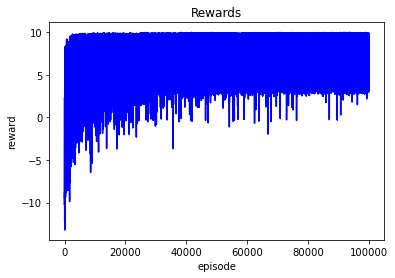

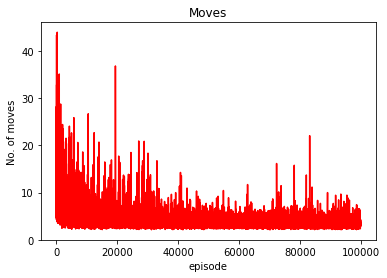

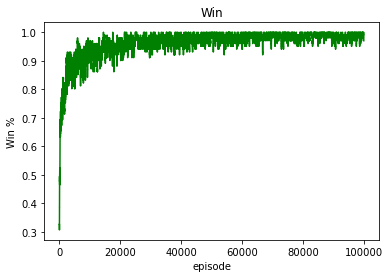

In [8]:
plot(r_save, 'Rewards', 'episode', 'reward', c = 'b', exp=True)
plot(n_moves_save, 'Moves', 'episode', 'No. of moves', c = 'r', exp=True)
plot(win_draw, 'Win', 'episode', 'Win %', c = 'g', exp=False)

## Reset network and variables

In [9]:
# neural network
model_nn = NeuralNetwork(input_size=N_in, output_size=N_a, hidden_size=N_h ,learning_rate = eta)
target_nn = copy.deepcopy(model_nn)

In [10]:
r_save = []
n_moves_save = []
win_draw = []

# Q Learning

In [11]:
for n in range(N_episodes):
  epsilon_f = epsilon_0 / (1 + beta * n)   # decay epsilon
  done = 0                                 # not done
  i = 1                                    # number of moves
  
  S, X, allowed_a = env.Initialise_game()      # reset environment

  X = np.concatenate([np.array(X), np.array([1])]).reshape(-1,1) # pad with one for bias

  tot_r = 0


  while done == 0:                           # start episode
    q_vals, h = model_nn.forward(X)          # get q values from network and preactivations

    action = choose_action(q_vals, allowed_a, epsilon_f) # choose action using epsilon greedy

    S_next, X_next, allowed_a_next, R, done = env.OneStep(action)  # take step
    X_next = np.concatenate([np.array(X_next), np.array([1])]).reshape(-1,1) 

    
    if done==1:  # episode is done
      target = R  # target reward
      if(R==10): # if won
        win_draw.append(1)
      else:      # if draw
        win_draw.append(0)

      target_vector = np.copy(q_vals)    
      target_vector[action] = target    # get target q value

    else:
      q_vals_next, _ = target_nn.forward(X_next)    # use target net to get future q value
      q_valid_next = q_vals_next * allowed_a_next
      q_valid_next[allowed_a_next==0] = -np.inf

      target = R + gamma * max(np.max(q_valid_next), 0) 
      target_vector = np.copy(q_vals)
      target_vector[action] = target


    model_nn.fit(target_vector, q_vals, h, X)   # fit the model
   
    tot_r += R  # add total reward

    # NEXT STATE AND CO. BECOME ACTUAL STATE...     
    S = np.copy(S_next)
    X = np.copy(X_next)
    allowed_a = np.copy(allowed_a_next)
    
    i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


  r_save.append(tot_r)
  n_moves_save.append(i)

  if(n>=1000 and n%1000==0):
    print("Episode: {:8.1f}, Mean reward: {:+5.2f}, Mean moves: {:5.2f}, Win %: {:.3f}".format(n, np.mean(r_save[-100:]), 
          np.mean(n_moves_save[-100:]), np.mean(win_draw[-100:])))
  
  if(n%n_target_updates==0):
      target_nn = copy.deepcopy(model_nn)   # update the target network

Episode:   1000.0, Mean reward: +1.53, Mean moves: 11.86, Win %: 0.700
Episode:   2000.0, Mean reward: +5.32, Mean moves:  6.34, Win %: 0.820
Episode:   3000.0, Mean reward: +5.56, Mean moves:  6.97, Win %: 0.840
Episode:   4000.0, Mean reward: +6.53, Mean moves:  6.28, Win %: 0.880
Episode:   5000.0, Mean reward: +6.04, Mean moves:  6.63, Win %: 0.860
Episode:   6000.0, Mean reward: +8.03, Mean moves:  5.10, Win %: 0.940
Episode:   7000.0, Mean reward: +7.68, Mean moves:  5.69, Win %: 0.930
Episode:   8000.0, Mean reward: +7.89, Mean moves:  4.83, Win %: 0.930
Episode:   9000.0, Mean reward: +7.59, Mean moves:  5.24, Win %: 0.920
Episode:  10000.0, Mean reward: +7.58, Mean moves:  3.66, Win %: 0.900
Episode:  11000.0, Mean reward: +7.33, Mean moves:  4.66, Win %: 0.900
Episode:  12000.0, Mean reward: +7.81, Mean moves:  4.35, Win %: 0.920
Episode:  13000.0, Mean reward: +8.22, Mean moves:  4.30, Win %: 0.940
Episode:  14000.0, Mean reward: +8.26, Mean moves:  4.17, Win %: 0.940
Episod

### Plot graphs

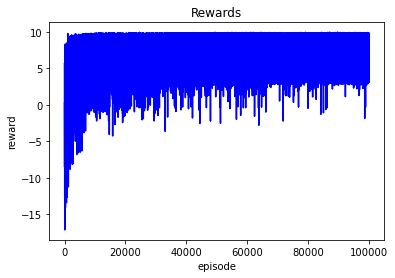

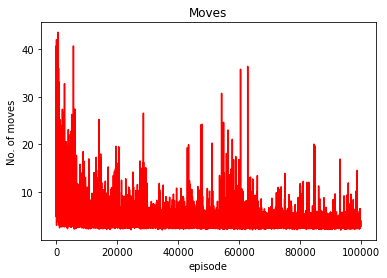

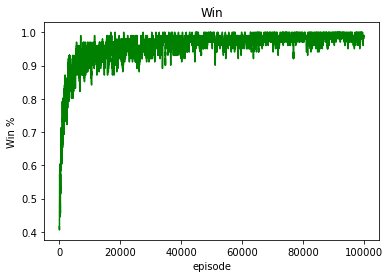

In [12]:
plot(r_save, 'Rewards', 'episode', 'reward', c = 'b', exp=True)
plot(n_moves_save, 'Moves', 'episode', 'No. of moves', c = 'r', exp=True)
plot(win_draw, 'Win', 'episode', 'Win %', c = 'g', exp=False)